In [1]:
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../src')

from data import *
from model import *
from train import *
import random
from make_cosmic_web import *

import cmasher as cmr

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
reload = False #force a reload of the data to change cuts, use_loops, periodic or use_loops

## get illustris positions
snapshot = 99
h = 0.704 # cosmology h, set to 1 if you want comoving Mpc

r_link = 1 #Mpc

cuts = {"minimum_log_stellar_mass": 9,
        "minimum_log_halo_mass": 10,
       "minimum_n_star_particles": 50}

undirected = True
periodic = False
use_loops = False

use_gal = False # True = use galaxy params to infer dark matter, False = use DM params to infer galaxy stuff

pad = r_link / 2 # how much padding to add around each subbox, so the separation in total will be 2 times this

split = 6 # N_subboxes = split**3

train_test_frac_split = 36

data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}.pkl')


In [3]:
def make_webs(
    tng_base_path="../illustris_data/TNG300-1/output", 
    snapshot=99, 
    r_link=5,
    pad=2.5,
    split=6,
    cuts=cuts, 
    use_gal=False, 
    h=0.704, 
    undirected=True, 
    periodic=False, 
    use_loops=False,
    normalization_params=normalization_params
):
    
    if use_gal:
        # use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass', 'subhalo_stellarhalfmassradius']
        use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass']
        y_cols = ['subhalo_loghalomass', 'subhalo_logvmax'] 
    else:
        use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_loghalomass', 'subhalo_logvmax'] 
        # y_cols = ['subhalo_logstellarmass', 'subhalo_stellarhalfmassradius']
        y_cols = ['subhalo_logstellarmass']

    subhalo_fields = ["SubhaloPos", "SubhaloMassType"] #just an initial check here

    subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

    pos = subhalos["SubhaloPos"][:,:3]
    min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))

    box_size = max_box/(h*1e3) #/(h*1000), pos units are in kpc


    subhalo_fields = [
            "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
            "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", "SubhaloFlag"
        ]
    subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

    halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
    halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

    subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3) #/(h*1000), pos units are in comoving kpc, so now in Mpc
    subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
    subhalo_halomass = subhalos["SubhaloMassType"][:,1]
    subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
    subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
    subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
    subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
    subhalo_flag = subhalos["SubhaloFlag"][:]
    halo_id = subhalos["SubhaloGrNr"][:]

    halo_mass = halos["Group_M_Crit200"][:]
    halo_primarysubhalo = halos["GroupFirstSub"][:]  # currently not used but might be good for magnitude gap
    group_pos = halos["GroupPos"][:] / (h*1e3)
    group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

    # get subhalos/galaxies      
    subhalos = pd.DataFrame(
        np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
        columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
    )
    subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
    subhalos['halo_id'] = subhalos['halo_id'].astype(int)
    subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

    subhalos.drop("subhalo_flag", axis=1, inplace=True)

    # impose stellar mass and particle cuts
    subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
    subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"])+10

    subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"])+10
    subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
    subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])

    subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()

    subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()

    subhalos.reset_index(drop = True)

    data = []
    for n in range(split):
        for g in range(split):
            for k in range(split):
                print(n,g,k)
                xlims = np.array([box_size/split*n+pad, box_size/split*(n+1)-pad])
                ylims = np.array([box_size/split*g+pad, box_size/split*(g+1)-pad])
                zlims = np.array([box_size/split*k+pad, box_size/split*(k+1)-pad])

                pos = np.vstack(subhalos[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

                xmask = np.logical_and(pos[:,0]>xlims[0],pos[:,0]<xlims[1])
                ymask = np.logical_and(pos[:,1]>ylims[0],pos[:,1]<ylims[1])
                zmask = np.logical_and(pos[:,2]>zlims[0],pos[:,2]<zlims[1])
                mask = np.logical_and(zmask, np.logical_and(xmask, ymask))

                df = subhalos.iloc[mask].copy()
                df.reset_index(drop=True)

                # remove extraneous columns
                df.drop(["subhalo_n_stellar_particles", "subhalo_stellarmass", "subhalo_halomass"], axis=1, inplace=True)

                # set new zero point

                df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']] - np.array([box_size/split*n+pad, box_size/split*g+pad, box_size/split*k+pad])

                #make positions for clustering

                pos = np.vstack(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

                kd_tree = ss.KDTree(pos, leafsize=25, boxsize=box_size)
                edge_index = kd_tree.query_pairs(r=r_link, output_type="ndarray")

                # normalize positions

                df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

                if undirected:
                # Add reverse pairs
                    reversepairs = np.zeros((edge_index.shape[0],2))
                    for i, pair in enumerate(edge_index):
                        reversepairs[i] = np.array([pair[1], pair[0]])
                    edge_index = np.append(edge_index, reversepairs, 0)

                    edge_index = edge_index.astype(int)

                    # Write in pytorch-geometric format
                    edge_index = edge_index.reshape((2,-1))
                    num_pairs = edge_index.shape[1]

                row, col = edge_index

                diff = pos[row]-pos[col]
                dist = np.linalg.norm(diff, axis=1)

                if periodic:
                    # Take into account periodic boundary conditions, correcting the distances
                    for i, pos_i in enumerate(diff):
                        for j, coord in enumerate(pos_i):
                            if coord > r_link:
                                diff[i,j] -= box_size  # Boxsize normalize to 1
                            elif -coord > r_link:
                                diff[i,j] += box_size  # Boxsize normalize to 1

                centroid = np.mean(pos,axis=0) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
                # centroid+=1.2

                unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
                unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
                unitdiff = diff/dist.reshape(-1,1)
                # Dot products between unit vectors
                cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
                cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

                edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)

                if use_loops:
                    loops = np.zeros((2,pos.shape[0]),dtype=int)
                    atrloops = np.zeros((pos.shape[0],3))
                    for i, posit in enumerate(pos):
                        loops[0,i], loops[1,i] = i, i
                        atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
                    edge_index = np.append(edge_index, loops, 1)
                    edge_attr = np.append(edge_attr, atrloops, 0)
                edge_index = edge_index.astype(int)

                x =  torch.tensor(np.vstack(df[use_cols].to_numpy()), dtype=torch.float)
                y =  torch.tensor(np.vstack(df[y_cols].to_numpy()), dtype=torch.float)
                edge_index = torch.tensor(edge_index, dtype=torch.long)
                edge_attr=torch.tensor(edge_attr, dtype=torch.float)
                pos = torch.tensor(pos, dtype=torch.float)

                data.append(Data(x=x, y=y, pos=pos, edge_index=edge_index, edge_attr=edge_attr))

                data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}.pkl')

                if not osp.isdir(osp.join(tng_base_path, 'cosmic_graphs')):
                    os.mkdir(osp.join(tng_base_path, 'cosmic_graphs'))

                with open(data_path, 'wb') as handle:
                    pickle.dump(data, handle)
                  

In [4]:

if osp.isfile(data_path) and not reload:
    print('File already exists')
else:
    print('Remaking dataset')
    make_webs(tng_base_path=tng_base_path, snapshot=snapshot, r_link = r_link, pad = pad, split=split, \
              cuts = cuts, use_gal = use_gal, h = h, undirected = undirected, periodic = periodic,\
              use_loops = use_loops)
    
data = pickle.load(open(data_path, 'rb'))

File already exists


In [5]:
data[:10]

[Data(x=[613, 8], edge_index=[2, 1886], edge_attr=[1886, 3], y=[613, 1], pos=[613, 3]),
 Data(x=[751, 8], edge_index=[2, 3132], edge_attr=[3132, 3], y=[751, 1], pos=[751, 3]),
 Data(x=[479, 8], edge_index=[2, 540], edge_attr=[540, 3], y=[479, 1], pos=[479, 3]),
 Data(x=[1150, 8], edge_index=[2, 6712], edge_attr=[6712, 3], y=[1150, 1], pos=[1150, 3]),
 Data(x=[1475, 8], edge_index=[2, 6842], edge_attr=[6842, 3], y=[1475, 1], pos=[1475, 3]),
 Data(x=[1203, 8], edge_index=[2, 3556], edge_attr=[3556, 3], y=[1203, 1], pos=[1203, 3]),
 Data(x=[137, 8], edge_index=[2, 26], edge_attr=[26, 3], y=[137, 1], pos=[137, 3]),
 Data(x=[632, 8], edge_index=[2, 1222], edge_attr=[1222, 3], y=[632, 1], pos=[632, 3]),
 Data(x=[967, 8], edge_index=[2, 2912], edge_attr=[2912, 3], y=[967, 1], pos=[967, 3]),
 Data(x=[969, 8], edge_index=[2, 2940], edge_attr=[2940, 3], y=[969, 1], pos=[969, 3])]

# Plot

In [7]:
def visualize_graph(data, draw_edges=True, projection="3d", edge_index=None, fontsize=12):

    fig = plt.figure(figsize=(8, 8), dpi=150)

    if projection=="3d":
        ax = fig.add_subplot(projection ="3d")
        pos = data.x[:,:3]
        mass = data.x[:,-2]
    elif projection=="2d":
        ax = fig.add_subplot()
        pos = data.x[:,:2]
        mass = data.x[:,-2]

    # Draw lines for each edge
    if data.edge_index is not None and draw_edges:
        for (src, dst) in data.edge_index.t().tolist():

            src = pos[src].tolist()
            dst = pos[dst].tolist()
            if projection=="3d":
                ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.1/r_link, color='black')
            elif projection=="2d":
                ax.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=0.1/r_link, color='black')

    # Plot nodes
    if projection=="3d":
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=(mass / 7)**3, zorder=1000, alpha=0.5, edgecolor='k', c=c3, linewidths=0.5)
    elif projection=="2d":
        ax.scatter(pos[:, 0], pos[:, 1], s=(mass / 7)**3, zorder=1000, alpha=0.5, edgecolor='k', c=c3, linewidths=0.5)

    # ax.xaxis.set_tick_params(labelsize=fontsize)
    # ax.yaxis.set_tick_params(labelsize=fontsize)
    # ax.zaxis.set_tick_params(labelsize=fontsize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # fig.savefig(f"{ROOT}/results/cosmic-graph.pdf", bbox_inches='tight', dpi=300)

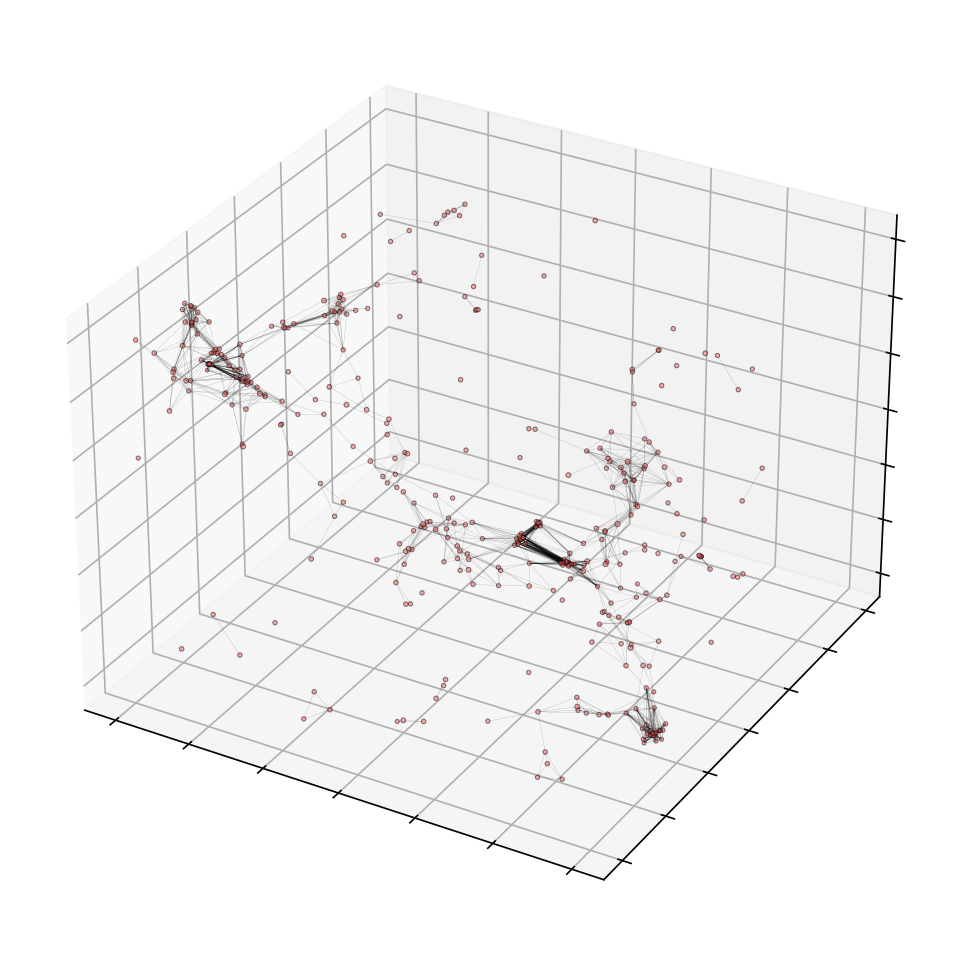

In [8]:
visualize_graph(data[0])

# Training

In [6]:
data = pickle.load(open(data_path, 'rb'))

node_features = data[0].x.shape[1]
out_features = data[0].y.shape[1]

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=1, 
    D_link=5,
    hidden_channels=128,
    latent_channels=128,
    loop=True,
    estimate_all_subhalos=True,
    use_global_pooling=False,
    n_out=out_features
)

model.to(device)


EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [7]:
from train import *

batch_size = 64

data_train = data[:-train_test_frac_split]
data_valid = data[-train_test_frac_split:]

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)


In [8]:
training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=1000,
    valid_frac=0.15, # fraction of dataset for validation
    test_frac=0.0,  # fraction of dataset for testing
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)


train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):

    # anneal 
    if (epoch == 600):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 5, 
            weight_decay=training_params["weight_decay"] / 5
        )
    elif (epoch == 900):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 25, 
            weight_decay=training_params["weight_decay"] / 25
        )

    train_loss = train(train_loader, model, optimizer, device, in_projection=False)
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >5.2f}     valid loss: {valid_loss: >5.2f}     average valid std: {np.mean(valid_std): >5.3f}")



Epoch  10    train loss: -2.24     valid loss: -2.44     average valid std: 0.000
Epoch  20    train loss: -2.43     valid loss: -2.47     average valid std: 0.000
Epoch  30    train loss: -2.44     valid loss: -2.47     average valid std: 0.000
Epoch  40    train loss: -2.44     valid loss: -2.47     average valid std: 0.000
Epoch  50    train loss: -2.44     valid loss: -2.47     average valid std: 0.000
Epoch  60    train loss: -2.35     valid loss: -1.84     average valid std: 0.000
Epoch  70    train loss: -3.47     valid loss: -2.28     average valid std: 0.001
Epoch  80    train loss: -2.62     valid loss: -4.42     average valid std: 0.001
Epoch  90    train loss: -5.86     valid loss: -5.54     average valid std: 0.001
Epoch 100    train loss: -5.97     valid loss: -6.12     average valid std: 0.001
Epoch 110    train loss: -6.32     valid loss: -6.34     average valid std: 0.001
Epoch 120    train loss: -4.78     valid loss: -4.94     average valid std: 0.001
Epoch 130    tra

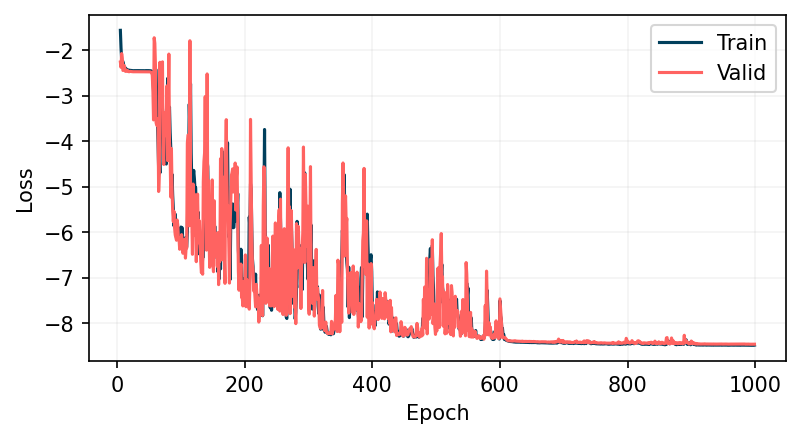

In [10]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(np.arange(5, training_params["n_epochs"]), train_losses[5:], c=c0, label="Train")
plt.plot(np.arange(5, training_params["n_epochs"]), valid_losses[5:], c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

# Results on stellar mass

In [11]:
_, _, p_valid, y_valid, logvar_p = validate(valid_loader, model, device)

p_valid = p_valid.reshape((-1, 1))

p_valid.shape, y_valid.shape

((33948, 1), (33948, 1))

In [12]:
p_log_Mstar = p_valid[:, 0]

y_log_Mstar = y_valid[:, 0]

# for plotting purposes
log_Mhalo = np.concatenate([d.x[:, -2] for d in data_valid])

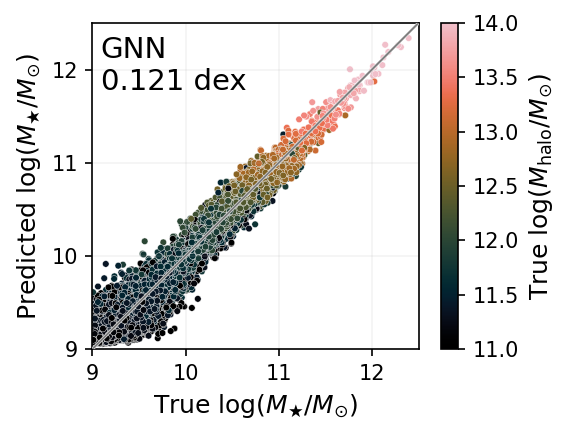

In [13]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"GNN\n{np.sqrt(np.mean((p_log_Mstar - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()

# plt.savefig(f'{ROOT}/results/painting-galaxies/GNN.pdf')

# Comparison against ~~abundance matching~~ random forest
(used as a proxy for abundance matching with only M_halo or V_max as input and M_star as output)

In [13]:
X_train = np.concatenate([d.x[:, -1] for d in data_train]).reshape((-1, 1))
y_train = np.concatenate([d.y[:, 0] for d in data_train])

X_train.shape, y_train.shape

((181799, 1), (181799,))

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

X_valid = np.concatenate([d.x[:, -1] for d in data_valid]).reshape((-1, 1))

p_log_Mstar_rf = rf.predict(X_valid)

In [15]:
p_log_Mstar_rf.shape, y_log_Mstar.shape

((33948,), (33948,))

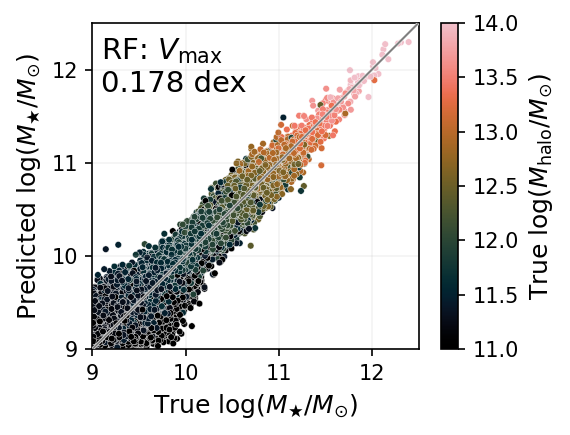

In [16]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_rf, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"RF: $V_{{\\rm max}}$\n{np.sqrt(np.mean((p_log_Mstar_rf - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)

plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("$V_{\\rm max}$ Subhalo Abundance Matching", fontsize=14)
plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/sham-Vmax.pdf')

In [17]:
X_train_Mh = np.concatenate([d.x[:, -2] for d in data_train]).reshape((-1, 1))
y_train = np.concatenate([d.y[:, 0] for d in data_train])

rf_Mh = RandomForestRegressor()
rf_Mh.fit(X_train_Mh, y_train)

X_valid_Mh = np.concatenate([d.x[:, -2] for d in data_valid]).reshape((-1, 1))

p_log_Mstar_rf_Mh = rf_Mh.predict(X_valid_Mh)

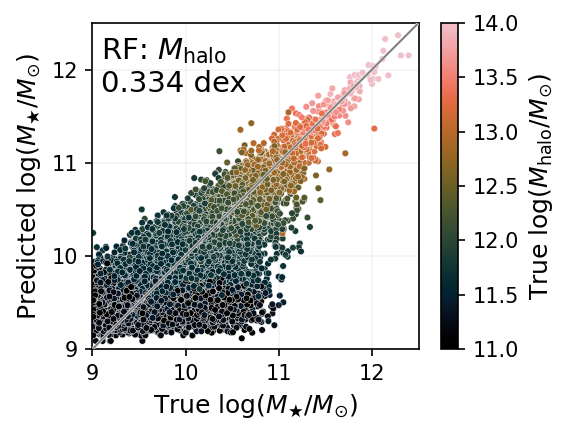

In [18]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_rf_Mh, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"RF: $M_{{\\rm halo}}$\n{np.sqrt(np.mean((p_log_Mstar_rf_Mh - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)

plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("$M_{\\rm halo}$ Subhalo Abundance Matching", fontsize=14)

plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/sham-Mhalo.pdf')

# Combined SHAM with both Vmax and Mhalo

In [19]:
X_train_combined = np.concatenate([d.x[:, -2:] for d in data_train]).reshape((-1, 2))
y_train = np.concatenate([d.y[:, 0] for d in data_train])

rf_combined = RandomForestRegressor()
rf_combined.fit(X_train_combined, y_train)

X_valid_combined = np.concatenate([d.x[:, -2:] for d in data_valid]).reshape((-1, 2))

p_log_Mstar_rf_combined = rf_combined.predict(X_valid_combined)

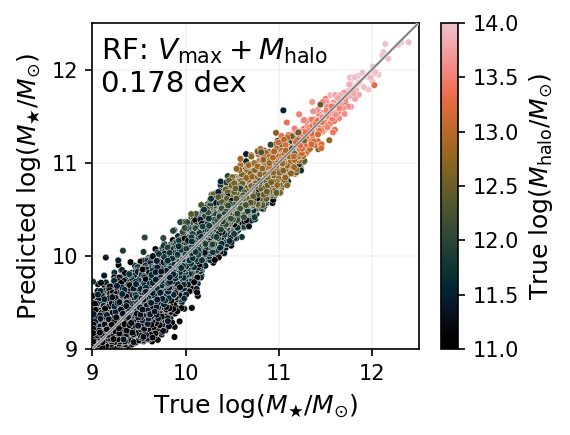

In [20]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_rf_combined, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"RF: $V_{{\\rm max}}+M_{{\\rm halo}}$\n{np.sqrt(np.mean((p_log_Mstar_rf - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)

plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("$V_{\\rm max}$ + $M_{\\rm halo}$ SHAM", fontsize=14)

plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/sham-Mhalo+Vmax.pdf')

# Multi-figure

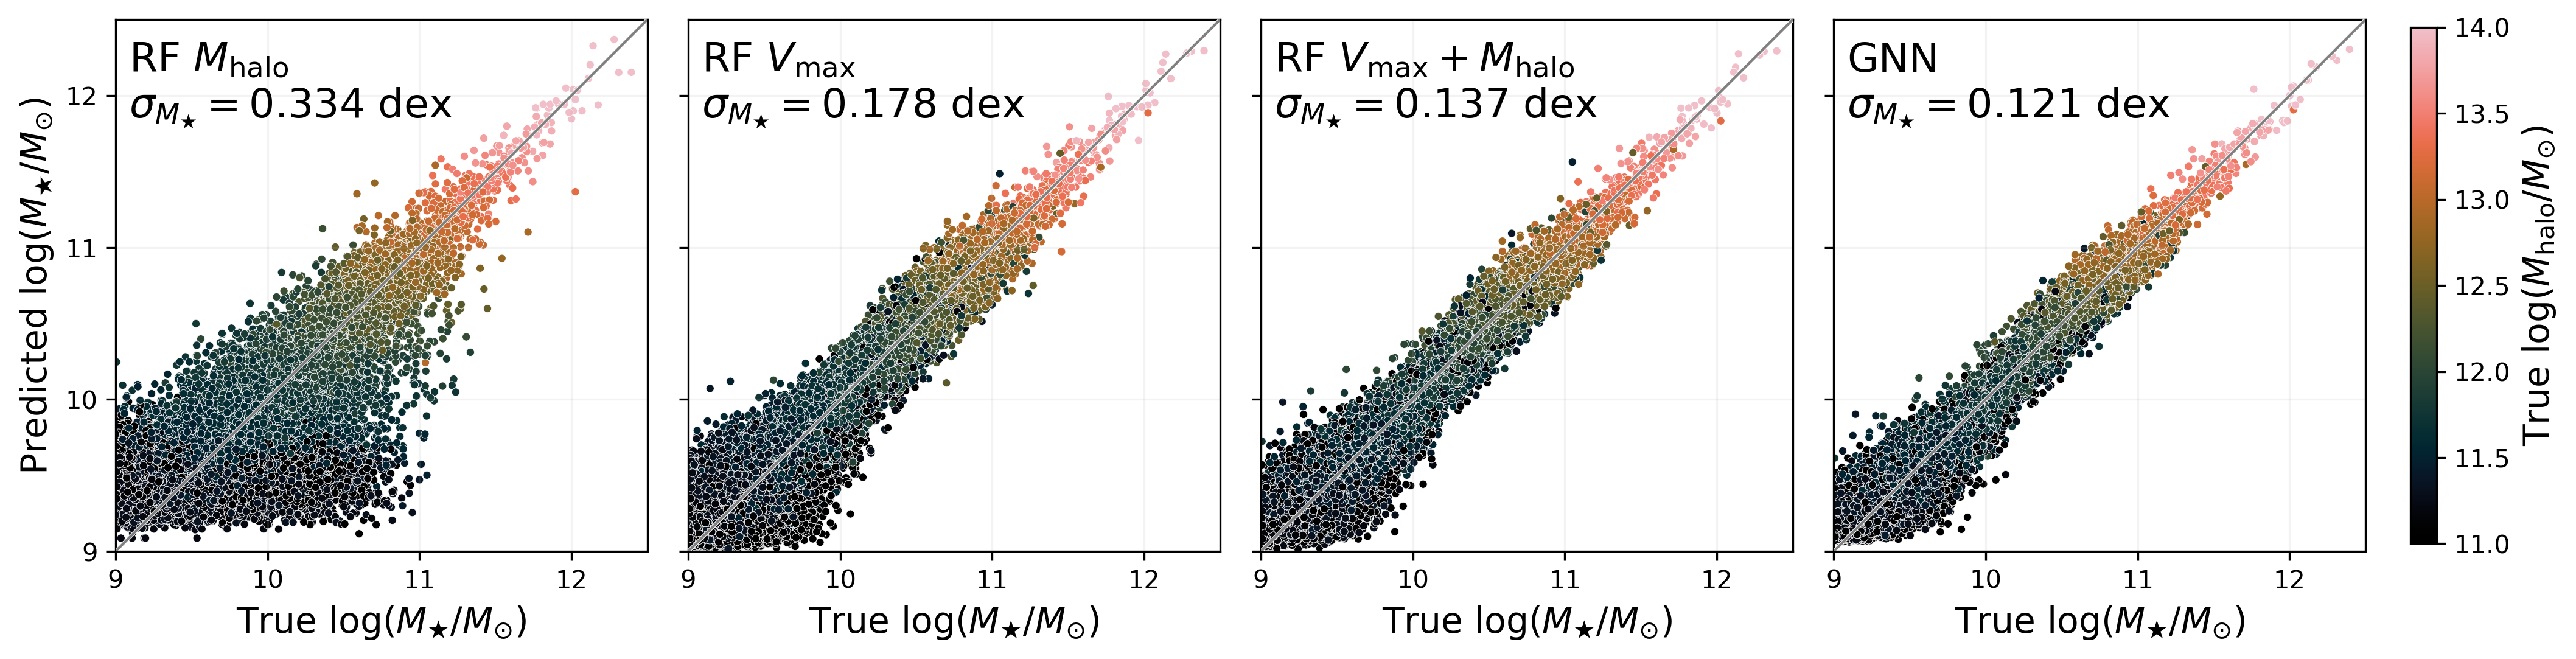

In [21]:
fig = plt.figure(figsize=(14, 3.75), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 4, wspace=0.05, left=0.05, right=0.95, bottom=0.025, top=0.975, )
ax1, ax2, ax3, ax4 = gs.subplots(sharey="row")

ax1.scatter(y_log_Mstar, p_log_Mstar_rf_Mh, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax1.text(0.025, 0.96, f"RF $M_{{\\rm halo}}$\n$\\sigma_{{M_{{\\bigstar}}}} = ${np.sqrt(np.mean((p_log_Mstar_rf_Mh - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax1.transAxes, fontsize=16)

ax2.scatter(y_log_Mstar, p_log_Mstar_rf, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax2.text(0.025, 0.96, f"RF $V_{{\\rm max}}$\n$\\sigma_{{M_{{\\bigstar}}}} = ${np.sqrt(np.mean((p_log_Mstar_rf - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax2.transAxes, fontsize=16)

ax3.scatter(y_log_Mstar, p_log_Mstar_rf_combined, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax3.text(0.025, 0.96, f"RF $V_{{\\rm max}}+M_{{\\rm halo}}$\n$\\sigma_{{M_{{\\bigstar}}}} = ${np.sqrt(np.mean((p_log_Mstar_rf_combined - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax3.transAxes, fontsize=16)

sc = ax4.scatter(y_log_Mstar, p_log_Mstar, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax4.text(0.025, 0.96, f"GNN\n$\\sigma_{{M_{{\\bigstar}}}} = ${np.sqrt(np.mean((p_log_Mstar - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax4.transAxes, fontsize=16)

cb = fig.colorbar(sc, ax=[ax1, ax2, ax3, ax4], pad=0.02, shrink=0.83)
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=14)


for ax in [ax1, ax2, ax3, ax4]:
    ax.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
    ax.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
    ax.grid(alpha=0.15)
    ax.set_xlim(9, 12.5)
    ax.set_ylim(9, 12.5)
    ax.set_xticks([9, 10, 11, 12])
    ax.set_yticks([9, 10, 11, 12])

    if ax == ax1:
        ax.set_ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=14)
    ax.set_xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=14)
    ax.set_aspect("equal")


plt.savefig(f'{ROOT}/results/painting-galaxies/GNN-vs-RF.png')